Deepstream Test1 description
--------------------------------------------------------------------------------------

This sample creates instance of "nvinfer" element. Instance of
the "nvinfer" uses TensorRT API to execute inferencing on a model. Using a
correct configuration for a nvinfer element instance is therefore very
important as considerable behaviors of the instance are parameterized
through these configs.

For reference, here are the config files used for this sample :
The 4-class detector (referred to as pgie in this sample) uses
    dstest1_pgie_config.txt

In this sample, we first create one instance of "nvinfer", referred as the pgie.
This is our 4 class detector and it detects for "Vehicle , RoadSign, TwoWheeler,
Person".
nvinfer element attach some MetaData to the buffer. By attaching
the probe function at the end of the pipeline, one can extract meaningful
information from this inference. Please refer the "osd_sink_pad_buffer_probe"
function in the sample code. For details on the Metadata format, refer to the
file "gstnvdsmeta.h"

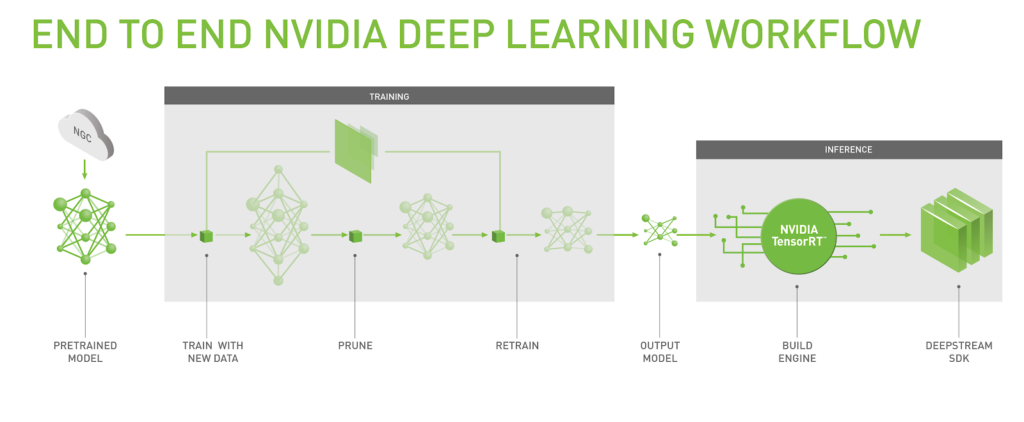


# Prerequisites


   * **DeepStream SDK 6.3**

To setup and install DeepStream 6.3, please follow the steps at https://developer.nvidia.com/deepstream-getting-started
    
   * **DeepStream Python Apps**

To install DeepStream Python Apps, follow the instructions in this repo: https://github.com/NVIDIA-AI-IOT/deepstream_python_apps

   * [**Jupyter Notebook**](https://jupyter.org/install)

To install jupyter notebook, run the following command:

```
pip3 install notebook
```

# Importing necessary libraries

In [ ]:
import sys
import os
sys.path.append('../')
sys.path.append('../apps/')
import gi
gi.require_version('Gst', '1.0')
from gi.repository import GLib, Gst
from common.is_aarch_64 import is_aarch64
from common.bus_call import bus_call

import pyds

# Declaring class label ids

In [ ]:
PGIE_CLASS_ID_VEHICLE = 0
PGIE_CLASS_ID_BICYCLE = 1
PGIE_CLASS_ID_PERSON = 2
PGIE_CLASS_ID_ROADSIGN = 3

# Necessary filepaths

In [ ]:
input_file = "/opt/nvidia/deepstream/deepstream/samples/streams/sample_720p.h264" # path to input stream
config_file = "../apps/deepstream-test1/dstest1_pgie_config.txt" # path to pgie config file

In [ ]:
def osd_sink_pad_buffer_probe(pad,info,u_data):
    frame_number=0
    #Intiallizing object counter with 0.
    obj_counter = {
        PGIE_CLASS_ID_VEHICLE:0,
        PGIE_CLASS_ID_PERSON:0,
        PGIE_CLASS_ID_BICYCLE:0,
        PGIE_CLASS_ID_ROADSIGN:0
    }
    num_rects=0

    gst_buffer = info.get_buffer()
    if not gst_buffer:
        print("Unable to get GstBuffer ")
        return

    # Retrieve batch metadata from the gst_buffer
    # Note that pyds.gst_buffer_get_nvds_batch_meta() expects the
    # C address of gst_buffer as input, which is obtained with hash(gst_buffer)
    batch_meta = pyds.gst_buffer_get_nvds_batch_meta(hash(gst_buffer))
    l_frame = batch_meta.frame_meta_list
    while l_frame is not None:
        try:
            # Note that l_frame.data needs a cast to pyds.NvDsFrameMeta
            # The casting is done by pyds.glist_get_nvds_frame_meta()
            # The casting also keeps ownership of the underlying memory
            # in the C code, so the Python garbage collector will leave
            # it alone.
            frame_meta = pyds.glist_get_nvds_frame_meta(l_frame.data)
        except StopIteration:
            break

        frame_number=frame_meta.frame_num
        num_rects = frame_meta.num_obj_meta
        l_obj=frame_meta.obj_meta_list
        while l_obj is not None:
            try:
                # Casting l_obj.data to pyds.NvDsObjectMeta
                obj_meta=pyds.glist_get_nvds_object_meta(l_obj.data)
            except StopIteration:
                break
            obj_counter[obj_meta.class_id] += 1
            try: 
                l_obj=l_obj.next
            except StopIteration:
                break

        # Acquiring a display meta object. The memory ownership remains in
        # the C code so downstream plugins can still access it. Otherwise
        # the garbage collector will claim it when this probe function exits.
        display_meta=pyds.nvds_acquire_display_meta_from_pool(batch_meta)
        display_meta.num_labels = 1
        py_nvosd_text_params = display_meta.text_params[0]
        # Setting display text to be shown on screen
        # Note that the pyds module allocates a buffer for the string, and the
        # memory will not be claimed by the garbage collector.
        # Reading the display_text field here will return the C address of the
        # allocated string. Use pyds.get_string() to get the string content.
        py_nvosd_text_params.display_text = "Frame Number={} Number of Objects={} Vehicle_count={} Person_count={}".format(frame_number, num_rects, obj_counter[PGIE_CLASS_ID_VEHICLE], obj_counter[PGIE_CLASS_ID_PERSON])

        # Now set the offsets where the string should appear
        py_nvosd_text_params.x_offset = 10
        py_nvosd_text_params.y_offset = 12

        # Font , font-color and font-size
        py_nvosd_text_params.font_params.font_name = "Serif"
        py_nvosd_text_params.font_params.font_size = 10
        # set(red, green, blue, alpha); set to White
        py_nvosd_text_params.font_params.font_color.set(1.0, 1.0, 1.0, 1.0)

        # Text background color
        py_nvosd_text_params.set_bg_clr = 1
        # set(red, green, blue, alpha); set to Black
        py_nvosd_text_params.text_bg_clr.set(0.0, 0.0, 0.0, 1.0)
        # Using pyds.get_string() to get display_text as string
        print(pyds.get_string(py_nvosd_text_params.display_text))
        pyds.nvds_add_display_meta_to_frame(frame_meta, display_meta)
        try:
            l_frame=l_frame.next
        except StopIteration:
            break
			
    return Gst.PadProbeReturn.OK	

# Initializing GStreamer

In [ ]:
# Standard initialization procedure
Gst.init(None)

# Create gstreamer elements
# Create Pipeline element that will form a connection of other elements
print("Creating Pipeline \n ")
pipeline = Gst.Pipeline()

if not pipeline:
    sys.stderr.write(" Unable to create Pipeline \n")

# Creating different elements of the stream

## Creating a source element for reading from a file

In [ ]:
print("Creating Source \n ")
source = Gst.ElementFactory.make("filesrc", "file-source")
if not source:
    sys.stderr.write(" Unable to create Source \n")

## Creating a h264 parser as the input file is an elementary h264 stream

In [ ]:
print("Creating H264Parser \n")
h264parser = Gst.ElementFactory.make("h264parse", "h264-parser")
if not h264parser:
    sys.stderr.write(" Unable to create h264 parser \n")

## Using nvdec_h264 for accelerated decoding on GPU

In [ ]:
print("Creating Decoder \n")
decoder = Gst.ElementFactory.make("nvv4l2decoder", "nvv4l2-decoder")
if not decoder:
    sys.stderr.write(" Unable to create Nvv4l2 Decoder \n")

## Creating a nvstreammux instance to form batches for one or more sources

In [ ]:
streammux = Gst.ElementFactory.make("nvstreammux", "Stream-muxer")
if not streammux:
    sys.stderr.write(" Unable to create NvStreamMux \n")

## Setting up nvinfer to run inference on the decoders output
### Note: Behaviour of inference is set through the config file 

In [ ]:
pgie = Gst.ElementFactory.make("nvinfer", "primary-inference")
if not pgie:
    sys.stderr.write(" Unable to create pgie \n")

## Using a converter to convert from NV12 to RGBA as required by nvosd

In [ ]:
nvvidconv = Gst.ElementFactory.make("nvvideoconvert", "convertor")
if not nvvidconv:
    sys.stderr.write(" Unable to create nvvidconv \n")

## Create OSD to draw on the converted RGBA buffer

In [ ]:
nvosd = Gst.ElementFactory.make("nvdsosd", "onscreendisplay")
if not nvosd:
    sys.stderr.write(" Unable to create nvosd \n")

# Finally render the osd output
## Creating the necessary sink: nv3dsink for Jetson, eglglessink for x86

In [ ]:
if is_aarch64():
    print("Creating nv3dsink \n")
    sink = Gst.ElementFactory.make("nv3dsink", "nv3d-sink")
    if not sink:
        sys.stderr.write(" Unable to create nv3dsink \n")
else:
    print("Creating EGLSink \n")
    sink = Gst.ElementFactory.make("nveglglessink", "nvvideo-renderer")
    if not sink:
        sys.stderr.write(" Unable to create egl sink \n")

# Setting PGIE and Streammux properties
### Suggested reading: dstest1_pgie_config.txt 

In [ ]:
# Edit this cell to change the inputs and the stream config
print("Playing file %s " % input_file)
source.set_property('location', \
                    input_file)
if os.environ.get('USE_NEW_NVSTREAMMUX') != 'yes': # Only set these properties if not using new gst-nvstreammux
    streammux.set_property('width', 1920)
    streammux.set_property('height', 1080)
    streammux.set_property('batched-push-timeout', 4000000)
streammux.set_property('batch-size', 1)
pgie.set_property('config-file-path', \
                  config_file)

Note: to use new gst-nvstreammux plugin, run `export USE_NEW_NVSTREAMMUX="yes"` BEFORE starting this jupyter notebook

# Adding all the above defined elements to a pipline and linking them

In [ ]:
print("Adding elements to Pipeline \n")
pipeline.add(source)
pipeline.add(h264parser)
pipeline.add(decoder)
pipeline.add(streammux)
pipeline.add(pgie)
pipeline.add(nvvidconv)
pipeline.add(nvosd)
pipeline.add(sink)
# we link the elements together
# file-source -> h264-parser -> nvh264-decoder ->
# nvinfer -> nvvidconv -> nvosd -> video-renderer
print("Linking elements in the Pipeline \n")
source.link(h264parser)
h264parser.link(decoder)

sinkpad = streammux.get_request_pad("sink_0")
if not sinkpad:
    sys.stderr.write(" Unable to get the sink pad of streammux \n")
srcpad = decoder.get_static_pad("src")
if not srcpad:
    sys.stderr.write(" Unable to get source pad of decoder \n")
srcpad.link(sinkpad)
streammux.link(pgie)
pgie.link(nvvidconv)
nvvidconv.link(nvosd)
nvosd.link(sink)

# Creating an event loop and feeding bus messages to it

In [ ]:
loop = GLib.MainLoop()
bus = pipeline.get_bus()
bus.add_signal_watch()
bus.connect ("message", bus_call, loop)

# Adding a probe to get the meta data generated

In [ ]:
# we add probe to the sink pad of the osd element, since by that time, 
# the buffer would have had got all the metadata.
osdsinkpad = nvosd.get_static_pad("sink")
if not osdsinkpad:
    sys.stderr.write(" Unable to get sink pad of nvosd \n")

osdsinkpad.add_probe(Gst.PadProbeType.BUFFER, osd_sink_pad_buffer_probe, 0)

# Starting the pipline

In [ ]:
print("Starting pipeline \n")
pipeline.set_state(Gst.State.PLAYING)
try:
    loop.run()
except:
    pass
# cleaning up as the pipeline comes to an end
pipeline.set_state(Gst.State.NULL)

# To set up inferencing interval:
    0: inference every frame
    1: inference every other frame (e.g. detect objects every other frame, use tracker to localize in-between)
    2: inference every third frame


Go to the pgie config file specified and change the interval as required. 



# Sample snapshot of the display

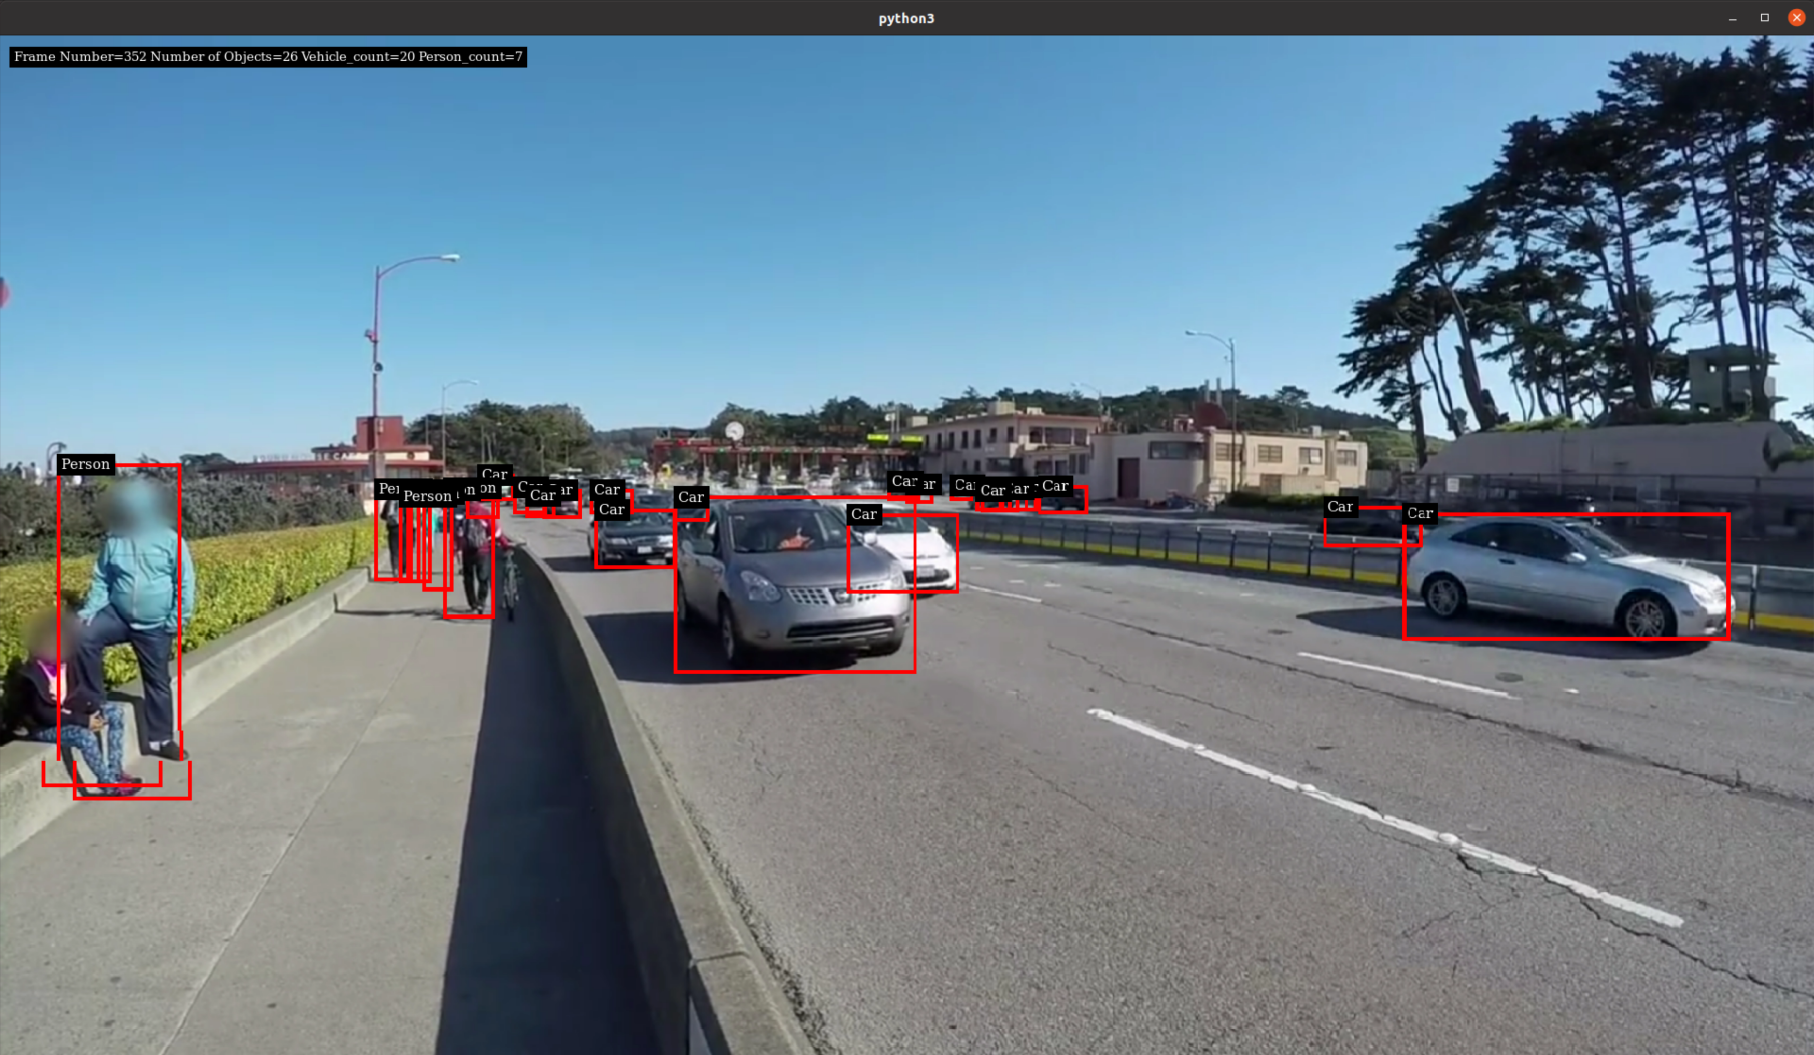

In [1]:
from IPython.display import Image
Image(filename='ds_test1.png')